In [2]:
import re
import pandas as pd
import numpy as np
import jieba
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout, Layer
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------------
# 1. 数据读取函数（正负样本）
# -------------------------------
def read_review_file(file_path, label, encoding="utf-8"):
    with open(file_path, 'r', encoding=encoding, errors='ignore') as f:
        data = f.read()
    pattern = re.compile(r'<review.*?>(.*?)</review>', re.S)
    matches = pattern.findall(data)
    texts = []
    for text in matches:
        text_clean = "\n".join([line.strip() for line in text.strip().splitlines() if line.strip()])
        if text_clean:
            texts.append(text_clean)
    labels = [label] * len(texts)
    return texts, labels

# -------------------------------
# 2. 中文分词函数
# -------------------------------
def chinese_tokenize(text):
    return " ".join(jieba.lcut(text))

# -------------------------------
# 3. Attention 层
# -------------------------------
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        # x: [batch_size, timesteps, features]
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = tf.keras.backend.sum(a * x, axis=1)
        return output

# -------------------------------
# 4. 准备训练数据（示例路径，修改为你的训练集路径）
# -------------------------------
cn_neg_file = r"D:\zuoye\商品评价文本情感分类\训练集\evaltask2_sample_data\cn_sample_data\sample.negative.txt"
cn_pos_file = r"D:\zuoye\商品评价文本情感分类\训练集\evaltask2_sample_data\cn_sample_data\sample.positive.txt"
en_neg_file = r"D:\zuoye\商品评价文本情感分类\训练集\evaltask2_sample_data\en_sample_data\sample.negative.txt"
en_pos_file = r"D:\zuoye\商品评价文本情感分类\训练集\evaltask2_sample_data\en_sample_data\sample.positive.txt"

cn_neg_text, cn_neg_label = read_review_file(cn_neg_file, 0, "utf-8")
cn_pos_text, cn_pos_label = read_review_file(cn_pos_file, 1, "utf-8")
en_neg_text, en_neg_label = read_review_file(en_neg_file, 0, "latin1")
en_pos_text, en_pos_label = read_review_file(en_pos_file, 1, "latin1")

train_texts = cn_neg_text + cn_pos_text + en_neg_text + en_pos_text
train_labels = cn_neg_label + cn_pos_label + en_neg_label + en_pos_label

# 中文分词
train_texts = [chinese_tokenize(t) for t in train_texts]

# -------------------------------
# 5. 文本序列化
# -------------------------------
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
sequences = tokenizer.texts_to_sequences(train_texts)
max_len = 500  # 限制最大长度
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
labels = np.array(train_labels)

# 划分训练/验证集
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences, labels, test_size=0.1, random_state=42, shuffle=True
)

vocab_size = len(tokenizer.word_index) + 1

# -------------------------------
# 6. 构建 BiLSTM + Attention 模型
# -------------------------------
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len)(input_layer)
bilstm = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
attention = Attention()(bilstm)
dense1 = Dense(64, activation='relu')(attention)
dropout = Dropout(0.5)(dense1)
output_layer = Dense(1, activation='sigmoid')(dropout)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# -------------------------------
# 7. 模型训练
# -------------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=10,
    callbacks=[early_stop],
    verbose=1
)

# -------------------------------
# 8. 测试集评估函数
# -------------------------------
def read_test_dataset(file_path, encoding="utf-8"):
    with open(file_path, 'r', encoding=encoding, errors='ignore') as f:
        data = f.read()
    pattern = re.compile(r'<review id="(\d+)"\s+label="(\d+)">(.*?)</review>', re.S)
    matches = pattern.findall(data)
    texts, labels = [], []
    for _, label, text in matches:
        text_clean = "\n".join([line.strip() for line in text.strip().splitlines() if line.strip()])
        texts.append(chinese_tokenize(text_clean))
        labels.append(int(label))
    return texts, np.array(labels)

# 示例：测试集
cn_file = r"D:\zuoye\商品评价文本情感分类\测试集标注\Sentiment Classification with Deep Learning\test.label.cn.txt"
en_file = r"D:\zuoye\商品评价文本情感分类\测试集标注\Sentiment Classification with Deep Learning\test.label.en.txt"

test_cn_texts, test_cn_labels = read_test_dataset(cn_file, "utf-8")
test_en_texts, test_en_labels = read_test_dataset(en_file, "utf-8")

test_cn_seq = pad_sequences(tokenizer.texts_to_sequences(test_cn_texts), maxlen=max_len, padding='post')
test_en_seq = pad_sequences(tokenizer.texts_to_sequences(test_en_texts), maxlen=max_len, padding='post')

# 评估
def evaluate_model(test_seq, test_labels, lang="CN"):
    preds = (model.predict(test_seq) > 0.5).astype(int)
    print(f"\n===== {lang} 测试集分类性能 =====")
    print(confusion_matrix(test_labels, preds))
    print(classification_report(test_labels, preds))

evaluate_model(test_cn_seq, test_cn_labels, "CN")
evaluate_model(test_en_seq, test_en_labels, "EN")


Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\wst20\AppData\Local\Temp\jieba.cache
Loading model cost 0.828 seconds.
Prefix dict has been built successfully.
C:\Users\wst20\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 500, 128)            │       7,840,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 500, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention (Attention)                │ (None, 128)                 │             628 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,948,661 (30.32 MB)

 Trainable params: 7,948,661 (30.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 114s 194ms/step - accuracy: 0.5916 - loss: 0.6488 - val_accuracy: 0.7644 - val_loss: 0.5106
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 137s 185ms/step - accuracy: 0.8253 - loss: 0.4083 - val_accuracy: 0.8094 - val_loss: 0.4198
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 146s 192ms/step - accuracy: 0.9077 - loss: 0.2451 - val_accuracy: 0.8104 - val_loss: 0.4787
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 141s 191ms/step - accuracy: 0.9490 - loss: 0.1413 - val_accuracy: 0.7989 - val_loss: 0.5786
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step

===== CN 测试集分类性能 =====
[[ 881  369]
 [ 236 1014]]
              precision    recall  f1-score   support

           0       0.79      0.70      0.74      1250
           1       0.73      0.81      0.77      1250

    accuracy                           0.76      2500
   macro avg       0.76      0.76      0.76      2500
weighted avg       0.76      0.76      0.76      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step

===== EN 测试集分

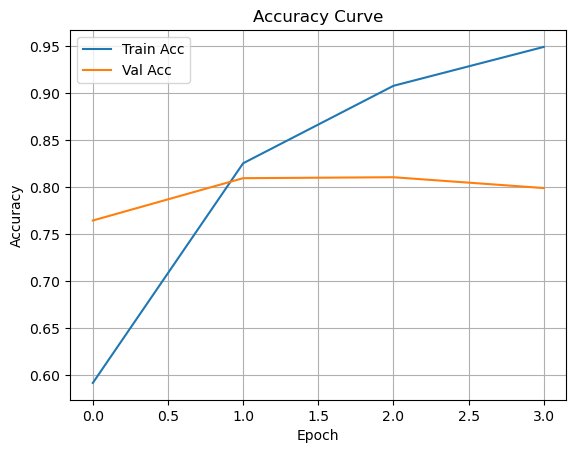

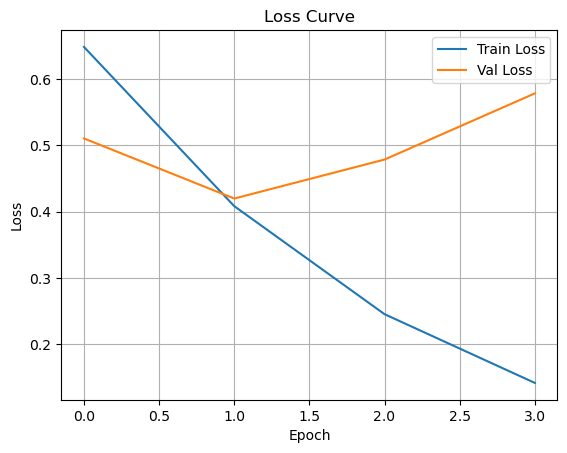

In [3]:
import matplotlib.pyplot as plt

# Accuracy 曲线
plt.figure()
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss 曲线
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step


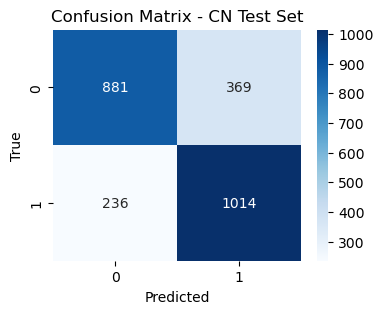

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step


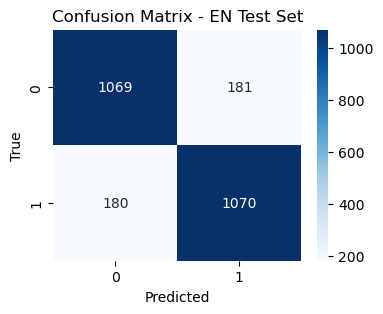

In [4]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion(test_seq, test_labels, lang="CN"):
    preds = (model.predict(test_seq) > 0.5).astype(int)
    cm = confusion_matrix(test_labels, preds)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.title(f"Confusion Matrix - {lang} Test Set")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_confusion(test_cn_seq, test_cn_labels, "CN")
plot_confusion(test_en_seq, test_en_labels, "EN")


79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step


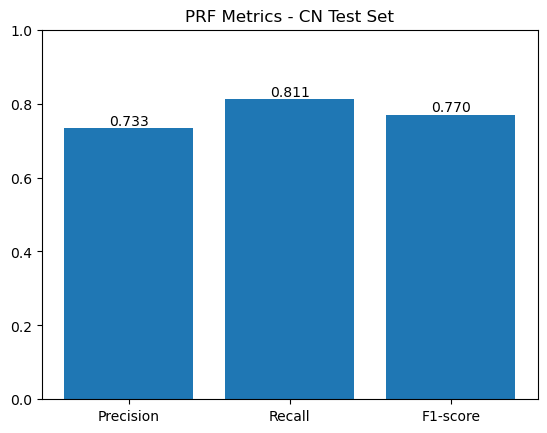

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step


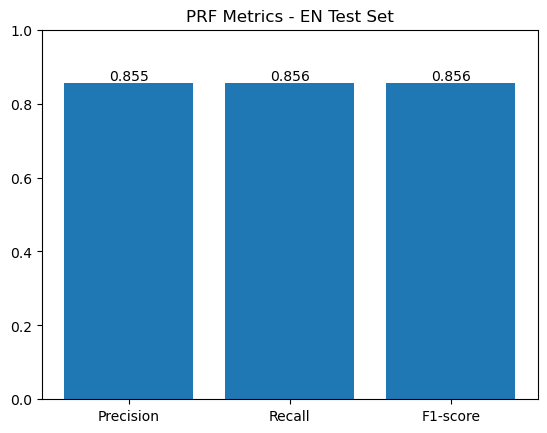

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score

def plot_prf(test_seq, test_labels, lang="CN"):
    preds = (model.predict(test_seq) > 0.5).astype(int)
    p = precision_score(test_labels, preds)
    r = recall_score(test_labels, preds)
    f = f1_score(test_labels, preds)

    plt.figure()
    plt.bar(["Precision", "Recall", "F1-score"], [p, r, f])
    plt.title(f"PRF Metrics - {lang} Test Set")
    for i, v in enumerate([p, r, f]):
        plt.text(i, v, f"{v:.3f}", ha='center', va='bottom')
    plt.ylim(0, 1)
    plt.show()

plot_prf(test_cn_seq, test_cn_labels, "CN")
plot_prf(test_en_seq, test_en_labels, "EN")


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(text, tokenizer, model, max_len=200):
    """
    text: 输入文本（字符串中文或英文均可）
    tokenizer: 用于将文本转为序列的分词器
    model: 训练好的深度学习模型（要求 forward 返回 attention 权重）
    """
    # 1. 文本 -> token 序列
    seq = tokenizer.texts_to_sequences([text])
    seq = tokenizer.pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    
    # 2. 模型前向传递，输出 attention 权重
    with torch.no_grad():
        output, attention_weights = model(seq)   # 模型需返回 attention

    # 3. 将 token ID 还原为文字
    tokens = tokenizer.sequences_to_texts(seq)[0].split()

    # attention 权重 shape: [batch, seq_len]
    att = attention_weights.squeeze().cpu().numpy()
    att = att[:len(tokens)]     # 去掉 padding 位置

    # 4. 可视化
    plt.figure(figsize=(12, 2))
    plt.bar(range(len(tokens)), att)
    plt.xticks(range(len(tokens)), tokens, rotation=45, fontsize=10)
    plt.title("Attention Weights Heatmap")
    plt.show()
